# Import netflow sequence and box encoding

In [2]:
import csv

infile = "data/flows_for_rnn_model_100000.csv"

fp = open(infile, 'r')
flowdata = [[int(x) for x in line] for line in csv.reader(fp)]
fp.close()

flowdata[:10]

[[1, 0, 2205, 122, 9501, 138, 1, 27, 28],
 [1, 0, 2244, 122, 8986, 122, 1, 22, 24],
 [1, 0, 2244, 122, 8986, 122, 1, 22, 24],
 [1, 0, 2408, 122, 8986, 122, 1, 20, 24],
 [1, 0, 2408, 122, 8986, 122, 1, 20, 24],
 [1, 0, 3022, 122, 9286, 122, 0, 12, 12],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 5741, 122, 9492, 122, 1, 0, 0]]

Note that the schema is:

<ul>
<li> timestamp
<li> duration (log)
<li> source computer
<li> source port
<li> destination computer
<li> destination port
<li> protocol
<li> nr packets (log)
<li> nr bytes (log)
</ul>

In [3]:
# load box/port info from json:

import json
import re

boxdata = json.load(open("data/boxport_data.json", 'r'))

def jsonIntKeys(x):
    if isinstance(x, dict):
            return {int(k):str(v) for k,v in x.items()}
    return x

def jsonIntVals(x):
    if isinstance(x, dict):
            return {str(k):int(v) for k,v in x.items()}
    return x

box_index = jsonIntVals( boxdata['box_indices'] )
index_box = jsonIntKeys( boxdata['indices_box'] )
port_index = jsonIntVals( boxdata['port_indices'] )
index_port = jsonIntKeys( boxdata['indices_port'] )

bbox = set([re.sub('[\"\n]+', "", s) for s in box_index.keys()])

In [10]:
# set RNN input vector sizes:

lg_duration = 24
lg_packets = 
lg_bytes = 32
nr_proto = 4
nr_box = len(index_box)   # 10109
nr_port = len(index_port) #   326

# Import box embedding

In [11]:
# create dict from box name to 4-dimensional coords:

infile = "data/box_coords.csv"

fp = open(infile, 'r')
boxcoords = {line[0]: [float(line[i]) for i in range(1,5)] for line in csv.reader(fp)}
fp.close()

In [12]:
import numpy as np

comp_embed = np.zeros([nr_box, 4])

for b in boxcoords.keys():
    comp_embed[box_index[b],:] = boxcoords[b]

Visual inspection:

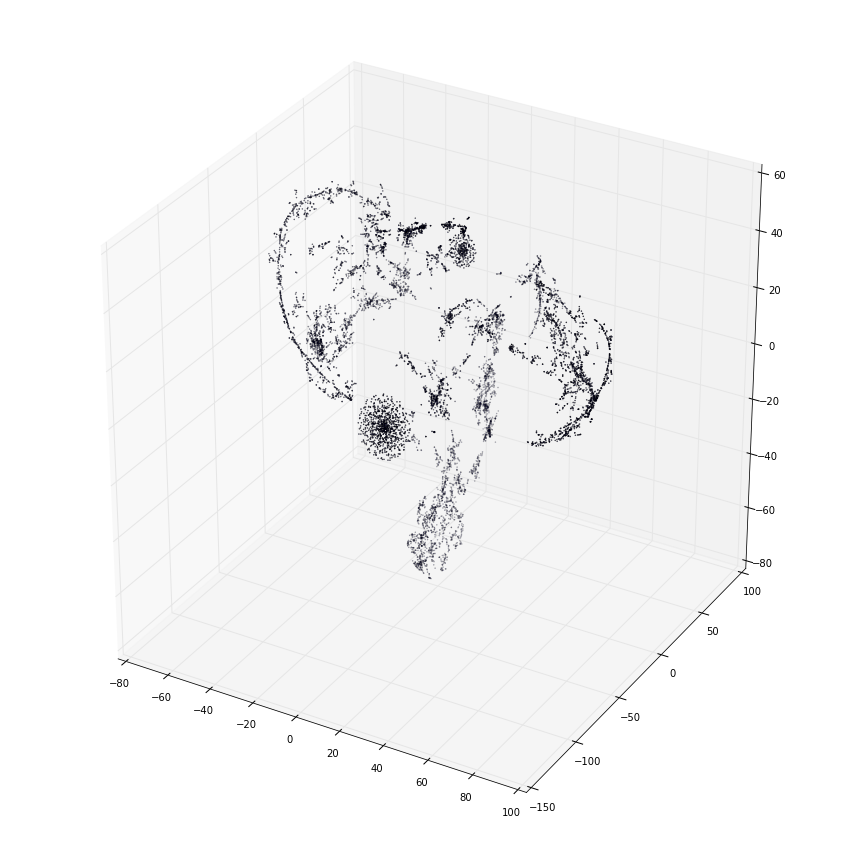

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = comp_embed[:,0]
y = comp_embed[:,1]
z = comp_embed[:,3]

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, s=0.2)
plt.show()

# RNN architecture

In [14]:
import sys
sys.setrecursionlimit(10000) # needed to prevent query-time bug...

from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.models import Model
from keras.engine.topology import merge
from keras.utils.visualize_util import plot

# hyperparameters:
nhidden = [512, 512]
unroll = 32
embed_dim = 4
dropout_W = 0.2 # input gates
dropout_U = 0.2 # recurrent connections

# netflow inputs:
src_input = Input(shape=(unroll,), dtype='int32', name='src_input')
dst_input = Input(shape=(unroll,), dtype='int32', name='dst_input')
src_pt_input = Input(shape=(unroll,), dtype='int32', name='src_pt')
dst_pt_input = Input(shape=(unroll,), dtype='int32', name='dst_pt')
proto_input = Input(shape=(unroll,), dtype='int32', name='proto')
duration_input = Input(shape=(unroll,), dtype='int32', name='duration')
packets_input = Input(shape=(unroll,), dtype='int32', name='packets')
bytes_input = Input(shape=(unroll,), dtype='int32', name='bytes')

# shared embedding for computer feeds:
comp_encoding = Embedding(output_dim=embed_dim, input_dim=nr_box, input_length=unroll, weights=[comp_embed], trainable=False)
src = comp_encoding(src_input)
dst = comp_encoding(dst_input)

# other embeddings:
src_pt = Embedding(output_dim=128, input_dim=nr_port, input_length=unroll)(src_pt_input)
dst_pt = Embedding(output_dim=128, input_dim=nr_port, input_length=unroll)(dst_pt_input)
proto = Embedding(output_dim=2, input_dim=nr_proto, input_length=unroll)(proto_input)
duration = Embedding(output_dim=4, input_dim=lg_duration, input_length=unroll)(duration_input)
packets = Embedding(output_dim=8, input_dim=lg_packets, input_length=unroll)(packets_input)
bytes = Embedding(output_dim=16, input_dim=lg_bytes, input_length=unroll)(bytes_input)

# merge:
data_merged = merge([src_pt, dst_pt, proto, duration, packets, bytes], mode='concat')

# add src computer for next time-step, as a query stream to train on:
next_src = Input(shape=(unroll,), dtype='int32', name='next_src')
query = comp_encoding(next_src)

# pass data and query to RNN layers:
inner = merge([data_merged, src, dst, query], mode='concat')
for i in range(len(nhidden)-1):
    inner = LSTM(nhidden[i], return_sequences=True, dropout_U=dropout_U, dropout_W=dropout_W)(inner)
inner = LSTM(nhidden[-1], return_sequences=False, dropout_U=dropout_U, dropout_W=dropout_W)(inner)
inner = Dropout(dropout_W)(inner)

# add softmax outputs:
proto_output = Dense(4, activation='softmax', name='proto_output')(inner)
duration_output = Dense(lg_duration, activation='softmax', name='duration_output')(inner)
packets_output = Dense(lg_packets, activation='softmax', name='packets_output')(inner)
bytes_output = Dense(lg_bytes, activation='softmax', name='bytes_output')(inner)
src_port_output = Dense(nr_port, activation='softmax', name='src_port_output')(inner)
dst_port_output = Dense(nr_port, activation='softmax', name='dst_port_output')(inner)

# add dst computer output:
next_dst = Dense(embed_dim, activation='relu', name='next_dst')(inner)

# put it all together:
model = Model(input=[src_input,
                     dst_input,
                     src_pt_input,
                     dst_pt_input,
                     proto_input,
                     duration_input,
                     packets_input, 
                     bytes_input,
                     next_src], 
              output=[proto_output,
                      duration_output,
                      packets_output,
                      bytes_output,
                      src_port_output,
                      dst_port_output,
                      next_dst])

loss_weights = [0.5/0.5, # proto
                1/1.5, # duration
                1/1.5, # packets
                1/2.0, # bytes
                2/1.0, # src_port
                2/1.0, # dst_prt
                8/500.0# next_dst
               ]
model.compile(optimizer='rmsprop', 
              loss=['categorical_crossentropy' for i in range(6)] + ['mse'],
              loss_weights=loss_weights )

# ...and summarise:
model.summary()
plot(model, to_file='model.png')

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
bytes (InputLayer)                 (None, 32)          0                                            
____________________________________________________________________________________________________
dst_pt (InputLayer)                (None, 32)          0                                            
____________________________________________________________________________________________________
duration (InputLayer)              (None, 32)          0                                            
____________________________________________________________________________________________________
packets (InputLayer)               (None, 32)          0                                            
___________________________________________________________________________________________

# Prepare training sequence

In [15]:
# inputs:

import numpy as np

# set nr training points:
N = len(flowdata) - 1
N = 10000

train = np.array(flowdata[:N+1])

def make_input_vectors(z, mx, unroll=unroll):
    n = len(z)
    X = np.zeros((n - unroll, unroll), dtype='int32')
    for i in range(n - unroll):
        X[i,:] = z[i: i + unroll]
    return X

src_in = make_input_vectors(train[range(N), 2], nr_box)
dst_in = make_input_vectors(train[range(N), 4], nr_box)
src_pt_in = make_input_vectors(train[range(N), 3], nr_port)
dst_pt_in = make_input_vectors(train[range(N), 5], nr_port)
proto_in = make_input_vectors(train[range(N), 6], nr_proto)
duration_in = make_input_vectors(train[range(N), 1], lg_duration)
packets_in = make_input_vectors(train[range(N), 7], lg_packets)
bytes_in = make_input_vectors(train[range(N),8], lg_bytes)
next_src_in = make_input_vectors(train[range(1,N+1),2], nr_box)

input = [src_in, dst_in, src_pt_in, dst_pt_in, proto_in, duration_in, packets_in, bytes_in, next_src_in]

In [16]:
# targets:

def make_onehot(x, n):
    N = len(x)-unroll
    out = np.zeros([N,n])
    for i in range(1,N):
        out[i, x[i]] = 1
    return out

proto_tgt = make_onehot(train[range(1,N+1), 6], nr_proto)
duration_tgt = make_onehot(train[range(1,N+1), 1], lg_duration)
packets_tgt = make_onehot(train[range(1,N+1), 7], lg_packets)
bytes_tgt = make_onehot(train[range(1,N+1),8], lg_bytes)
src_pt_tgt = make_onehot(train[range(1,N+1), 3], nr_port)
dst_pt_tgt = make_onehot(train[range(1,N+1), 5], nr_port)

def make_nextdst(x, cmp_code):
    N = len(x)-unroll
    out = np.zeros([N, embed_dim])
    for i in range(N):
        out[i,:] = cmp_code[x[i],:]
    return out

dst_tgt = make_nextdst(train[range(1,N+1), 4], comp_embed)
target = [proto_tgt, duration_tgt, packets_tgt, bytes_tgt, src_pt_tgt, dst_pt_tgt, dst_tgt]

# Testing the architecture (optional)

In [17]:
# theano:

test = [x[:100] for x in input]
output = model.predict(test)
wts = model.get_weights()

print([y.shape for y in output])
print(output[0][1:10])

[(100, 4), (100, 24), (100, 32), (100, 32), (100, 326), (100, 326), (100, 4)]
[[ 0.29986417  0.29869291  0.1530991   0.24834381]
 [ 0.27382827  0.26610911  0.16090602  0.29915661]
 [ 0.2232468   0.29763278  0.16305611  0.3160643 ]
 [ 0.24453723  0.31609565  0.17197281  0.2673943 ]
 [ 0.27494654  0.27990282  0.14224298  0.30290765]
 [ 0.31568319  0.32054704  0.13126993  0.23249982]
 [ 0.32516825  0.30422404  0.14431848  0.22628923]
 [ 0.34981665  0.30116573  0.157415    0.19160262]
 [ 0.32056403  0.34247592  0.14802174  0.18893832]]


In [23]:
# tensorflow:

output = model(input)
output

In [18]:
# of particular interest is the shared computer encoding, which will also be needed in the loss function:
wts = model.get_weights()
for w in wts: print(w.shape)

(326, 128)
(4, 2)
(24, 4)
(32, 8)
(32, 16)
(326, 128)
(10109, 4)
(298, 512)
(512, 512)
(512,)
(298, 512)
(512, 512)
(512,)
(298, 512)
(512, 512)
(512,)
(298, 512)
(512, 512)
(512,)
(512, 512)
(512, 512)
(512,)
(512, 512)
(512, 512)
(512,)
(512, 512)
(512, 512)
(512,)
(512, 512)
(512, 512)
(512,)
(512, 32)
(32,)
(512, 326)
(326,)
(512, 24)
(24,)
(512, 4)
(4,)
(512, 32)
(32,)
(512, 4)
(4,)
(512, 326)
(326,)


In [19]:
# check the computer embedding:

wts = model.get_weights()
print(wts[6][0])
print(comp_embed[0])

[  6.40943575  -0.33822641  49.54575729  39.56111526]
[  6.4094359   -0.33822642  49.54575826  39.56111665]


# Training the model

In [20]:
nr_epochs = 20

from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'total':[], 
                       'proto':[], 
                       'duration':[], 
                       'packets':[],
                       'bytes':[], 
                       'src_port':[], 
                       'dst_port':[], 
                       'next_dst':[] }
    def on_batch_end(self, batch, logs={}):
        self.losses['total'].append(logs.get('loss'))
        self.losses['proto'].append(logs.get('proto_output_loss'))
        self.losses['duration'].append(logs.get('duration_output_loss'))
        self.losses['packets'].append(logs.get('packets_output_loss'))
        self.losses['bytes'].append(logs.get('bytes_output_loss'))
        self.losses['src_port'].append(logs.get('src_port_output_loss'))
        self.losses['dst_port'].append(logs.get('dst_port_output_loss'))
        self.losses['next_dst'].append(logs.get('next_dst_loss'))

history = LossHistory()

model.fit(input, target, 
          nb_epoch=nr_epochs, 
          verbose=1, 
          callbacks=[history])

Epoch 1/20
9968/9968 [==============================] - 252s - loss: 19.7340 - proto_output_loss: 0.5920 - duration_output_loss: 1.5987 - packets_output_loss: 2.1754 - bytes_output_loss: 2.7834 - src_port_output_loss: 1.2313 - dst_port_output_loss: 1.2465 - next_dst_loss: 642.4273   
Epoch 2/20
9968/9968 [==============================] - 251s - loss: 16.9324 - proto_output_loss: 0.4974 - duration_output_loss: 1.4605 - packets_output_loss: 1.9818 - bytes_output_loss: 2.5153 - src_port_output_loss: 0.9477 - dst_port_output_loss: 0.9210 - next_dst_loss: 571.5654   
Epoch 3/20
9968/9968 [==============================] - 250s - loss: 15.1898 - proto_output_loss: 0.4274 - duration_output_loss: 1.3677 - packets_output_loss: 1.8622 - bytes_output_loss: 2.3489 - src_port_output_loss: 0.8187 - dst_port_output_loss: 0.7703 - next_dst_loss: 516.0438   
Epoch 4/20
9968/9968 [==============================] - 250s - loss: 13.9761 - proto_output_loss: 0.3635 - duration_output_loss: 1.2732 - packets

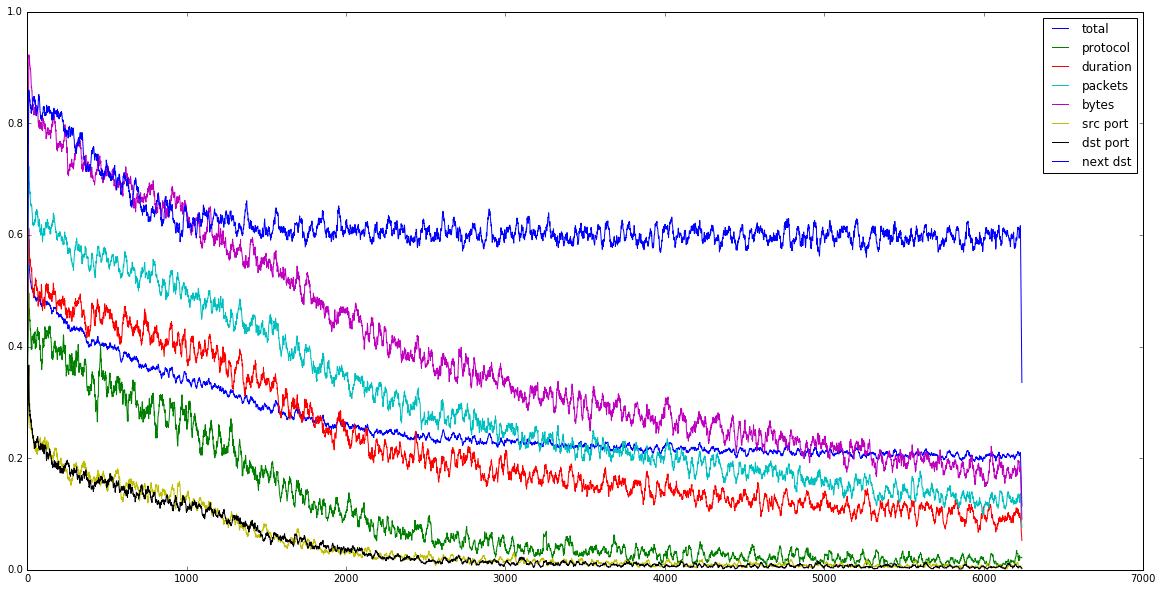

In [21]:
# show the SGD progress:

%matplotlib inline
import matplotlib.pyplot as plt

def movingaverage(x, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(x, window, 'same')

total_loss = history.losses['total']/np.max(history.losses['total'])
proto_loss = history.losses['proto']/np.max(history.losses['proto'])
duration_loss = history.losses['duration']/np.max(history.losses['duration'])
packets_loss = history.losses['packets']/np.max(history.losses['packets'])
bytes_loss = history.losses['bytes']/np.max(history.losses['bytes'])
src_port_loss = history.losses['src_port']/np.max(history.losses['src_port'])
dst_port_loss = history.losses['dst_port']/np.max(history.losses['dst_port'])
next_dst_loss = history.losses['next_dst']/np.max(history.losses['next_dst'])

plt.figure(figsize=(20,10))
wsize = 20

plt.plot(movingaverage(total_loss, wsize), label='total')
plt.plot(movingaverage(proto_loss, wsize), label='protocol')
plt.plot(movingaverage(duration_loss, wsize), label='duration')
plt.plot(movingaverage(packets_loss, wsize), label='packets')
plt.plot(movingaverage(bytes_loss, wsize), label='bytes')
plt.plot(movingaverage(src_port_loss, wsize), label='src port')
plt.plot(movingaverage(dst_port_loss, wsize), label='dst port')
plt.plot(movingaverage(next_dst_loss, wsize), label='next dst')

plt.legend(loc='upper right')
plt.show()

In [22]:
np.savez("data/rnn_512_512_wts.npz", wts=wts)

In [23]:
train[:10,:]

array([[   1,    0, 2205,  122, 9501,  138,    1,   27,   28],
       [   1,    0, 2244,  122, 8986,  122,    1,   22,   24],
       [   1,    0, 2244,  122, 8986,  122,    1,   22,   24],
       [   1,    0, 2408,  122, 8986,  122,    1,   20,   24],
       [   1,    0, 2408,  122, 8986,  122,    1,   20,   24],
       [   1,    0, 3022,  122, 9286,  122,    0,   12,   12],
       [   1,    0, 5354,  122, 9484,    0,    1,    0,    1],
       [   1,    0, 5354,  122, 9484,    0,    1,    0,    1],
       [   1,    0, 5354,  122, 9484,    0,    1,    0,    1],
       [   1,    0, 5741,  122, 9492,  122,    1,    0,    0]])

(array([  3.80000000e+02,   8.79000000e+02,   5.32000000e+02,
          6.30300000e+03,   1.89100000e+03,   2.00000000e+00,
          5.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          5.00000000e+00]),
 array([   0. ,   31.3,   62.6,   93.9,  125.2,  156.5,  187.8,  219.1,
         250.4,  281.7,  313. ]),
 <a list of 10 Patch objects>)

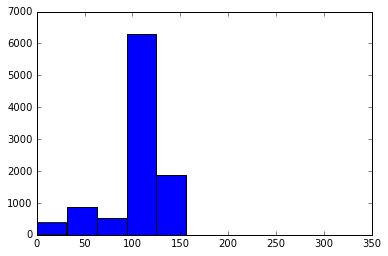

In [24]:
plt.hist(train[:,5])